In [1]:
from __future__ import annotations

import pathlib

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
def load_data(
    filepaths: list[tuple[str, str, pathlib.Path]],
) -> polars.DataFrame:
    dfs = []
    for scenario, label, filepath in filepaths:
        df = polars.read_csv(filepath)
        df = df.with_columns(
            polars.lit(scenario).alias('scenario'),
            polars.lit(label).alias('label'),
        )
        dfs.append(df)
    return polars.concat(dfs).sort(
        'label',
        'exchange',
        'proxystore',
        'data_size_bytes',
    )

In [3]:
local_runs = pathlib.Path('../runs-prod/exchange-perf-local-v2/')
remote_runs = pathlib.Path('../runs-prod/exchange-perf-remote-v2/')
filepaths = [
    ('local', 'Baseline', local_runs / '2025-04-05-21-38-05/results.csv'),
    ('local', '+Pass-by-ref', local_runs / '2025-04-05-21-43-27/results.csv'),
    ('local', '+Direct', local_runs / '2025-04-05-21-44-29/results.csv'),
    (
        'remote',
        '+Pass-by-ref',
        remote_runs / '2025-04-05-22-19-58/results.csv',
    ),
    ('remote', 'Baseline', remote_runs / '2025-04-05-22-26-32/results.csv'),
]
raw = load_data(filepaths)

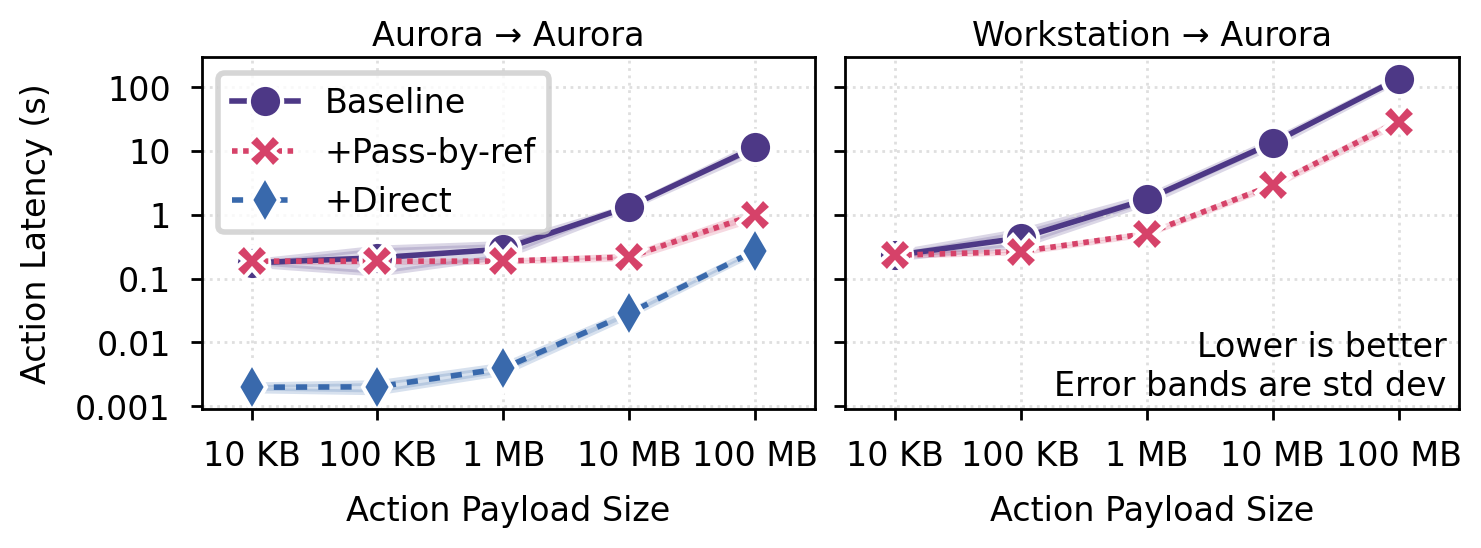

In [4]:
fig, axs = plt.subplots(1, 2, sharey=True)

data = raw.filter(polars.col('data_size_bytes') >= 10_000)
local_data = data.filter(polars.col('scenario') == 'local')
remote_data = data.filter(polars.col('scenario') == 'remote')

xticks = sorted(set(data['data_size_bytes'].to_list()))
xtick_labels = ['10 KB', '100 KB', '1 MB', '10 MB', '100 MB']
yticks = [0.001, 0.01, 0.1, 1, 10, 100]

hue_order = ['Baseline', '+Pass-by-ref', '+Direct']
palette = {
    'Baseline': '#4D3886',
    '+Pass-by-ref': '#D64269',
    '+Direct': '#3969AC',
}
markers = {
    'Baseline': 'o',
    '+Pass-by-ref': 'X',
    '+Direct': 'd',
}
dashes = {'+Direct': (2, 2), '+Pass-by-ref': (1, 1), 'Baseline': ()}

handle = seaborn.lineplot(
    local_data,
    x='data_size_bytes',
    y='latency_s',
    hue='label',
    hue_order=hue_order,
    errorbar='sd',
    style='label',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs[0],
)
axs[0].set_title('Aurora → Aurora')
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Action Payload Size',
    ylabel='Action Latency (s)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels(xtick_labels)
axs[0].tick_params(axis='x', which='minor', bottom=False)

handle = seaborn.lineplot(
    remote_data,
    x='data_size_bytes',
    y='latency_s',
    hue='label',
    hue_order=hue_order,
    errorbar='sd',
    style='label',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs[1],
)
axs[1].set_title('Workstation → Aurora')
handles, _ = axs[0].get_legend_handles_labels()
axs[0].legend(
    loc='upper left',
    handles=handles,
    title=None,
)
axs[1].get_legend().remove()

_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Action Payload Size',
    ylabel='Action Latency (s)',
)
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticks])
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels(xtick_labels)
axs[1].tick_params(axis='x', which='minor', bottom=False)

axs[0].set(ylim=[0.0009, 300])
for ax in axs:
    ax.set(xlim=[4_000, 300_000_000])
fig.subplots_adjust(wspace=2)

axs[1].annotate(
    'Lower is better\nError bands are std dev',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

fig.tight_layout()
plt.draw()
fig.set_size_inches(3.5, 1)
fig.savefig('figures/exchange-ablation.pdf')

In [5]:
raw.group_by(
    'label',
    'scenario',
    'exchange',
    'proxystore',
    'data_size_bytes',
    maintain_order=True,
).mean()

label,scenario,exchange,proxystore,data_size_bytes,latency_s
str,str,str,bool,i64,f64
"""+Direct""","""local""","""HybridExchange""",false,1000,0.012186
"""+Direct""","""local""","""HybridExchange""",false,10000,0.001988
"""+Direct""","""local""","""HybridExchange""",false,100000,0.002018
"""+Direct""","""local""","""HybridExchange""",false,1000000,0.003929
"""+Direct""","""local""","""HybridExchange""",false,10000000,0.028821
"""+Direct""","""local""","""HybridExchange""",false,100000000,0.272674
"""+Pass-by-ref""","""local""","""RedisExchange""",true,1000,0.192983
"""+Pass-by-ref""","""remote""","""RedisExchange""",true,1000,0.295177
"""+Pass-by-ref""","""local""","""RedisExchange""",true,10000,0.188065
